In [39]:
import requests
import os
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import gc


In [40]:
import scanpy as sc
print(sc.__version__)

1.11.5


/var/folders/yn/hz3ff0v92wncd37sxx_wrqhc0000gq/T/ipykernel_85299/289967954.py:2: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(sc.__version__)


## Set parameters and paths

In [41]:
# Define parameters
res = 1
n_hvg = 2000

In [42]:
# Define the input and output directories
input_dir = 'Input_files'

# Create the output directory if it does not exist
if not os.path.exists(input_dir):
    os.makedirs(input_dir) 

## Analysis for Gabritto_2024

### Load data

In [43]:
studyID = 'Gabritto_2024'
'''
download_link = 'https://datasets.cellxgene.cziscience.com/145aadbe-fd91-4592-bf14-3b4c644a2141.h5ad'
new_filename = f"Input_files/{studyID}.h5ad"
response = requests.get(download_link)
with open(new_filename, 'wb') as f:
        f.write(response.content)
print(f"File downloaded and saved as {new_filename}")
'''

'\ndownload_link = \'https://datasets.cellxgene.cziscience.com/145aadbe-fd91-4592-bf14-3b4c644a2141.h5ad\'\nnew_filename = f"Input_files/{studyID}.h5ad"\nresponse = requests.get(download_link)\nwith open(new_filename, \'wb\') as f:\n        f.write(response.content)\nprint(f"File downloaded and saved as {new_filename}")\n'

### Preprocess and clustering

Start process Gabritto_2024
    Before process: number of obs 42486, number of var 36412
    Start QC
    After process: number of obs 42483, number of var 31747
    It is Normalized and Log-Transformed data, no need to run normalization


/Users/yelin.zhao/opt/anaconda3/envs/py_3.12_base_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


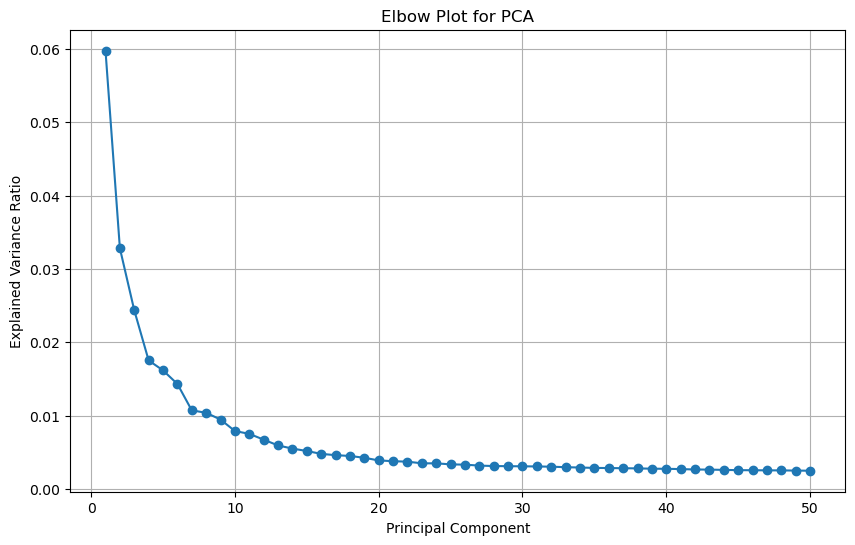

In [44]:
studyID = 'Gabritto_2024'
file = 'Gabritto_2024.h5ad'
print(f'Start process {studyID}')
adata=sc.read_h5ad(os.path.join(input_dir,file))
print(f'    Before process: number of obs {adata.n_obs}, number of var {adata.n_vars}')

adata.layers["counts"]=adata.X.copy()
adata.var['GeneID']=adata.var.index
adata.var.set_index('feature_name',inplace=True)
if adata.raw is not None:
    adata.raw.var.set_index('feature_name', inplace=True)
else:
    print("    adata.raw is None, skipping setting index.")
adata.var["mt"]=adata.var_names.str.startswith("MT-")

adata.obs['nCount_RNA'] = adata.obs['Number of UMIs']
adata.obs['nFeature_RNA'] = adata.obs['Genes detected']
del adata.obs['Number of UMIs']
del adata.obs['Genes detected']

# QC
print(f'    Start QC')
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"],inplace=True,log1p=True)
sc.pp.filter_genes(adata,min_cells=3)
adata=adata[adata.obs['nFeature_RNA']>200,:]
adata=adata[adata.obs['pct_counts_mt']<10,:]
adata=adata[adata.obs['nCount_RNA']>400,:]
adata=adata[adata.obs['nCount_RNA']<60000,:]
print(f'    After process: number of obs {adata.n_obs}, number of var {adata.n_vars}')

print(f'    It is Normalized and Log-Transformed data, no need to run normalization')

sc.pp.highly_variable_genes(adata,n_top_genes=n_hvg)
sc.tl.pca(adata)
explained_variance_ratio = adata.uns['pca']['variance_ratio']
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)

### Remove non-microglials

In [45]:
adata.backup = adata

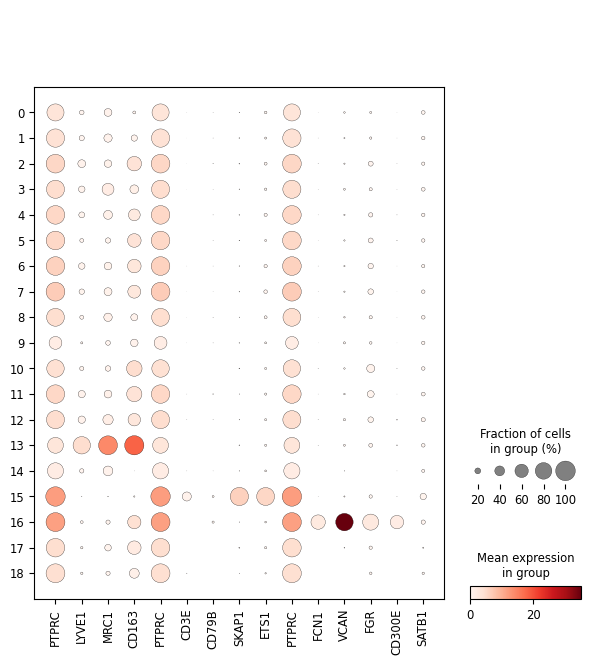

In [46]:
goi=['PTPRC', 'LYVE1', 'MRC1', 'CD163','PTPRC', 'CD3E', 'CD79B', 'SKAP1', 'ETS1','PTPRC', 'FCN1', 'VCAN', 'FGR', 'CD300E','SATB1']
goi_in_adata=[gene for gene in goi if gene in adata.var_names]
sc.pl.dotplot(adata, goi_in_adata, groupby="leiden");

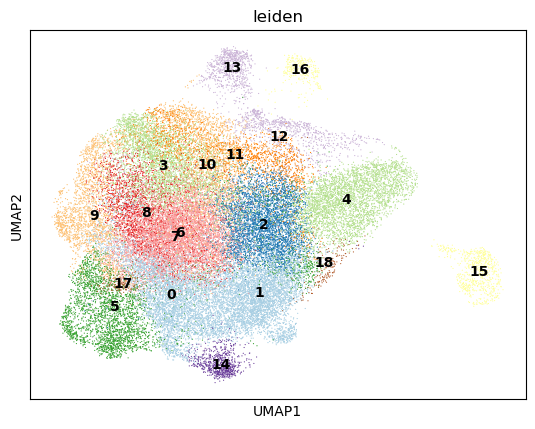

In [47]:
sc.pl.umap(adata, color=['leiden'], palette='Paired',legend_loc='on data', save=f'_{studyID}_microglia_leiden_res{res}.pdf')    

In [48]:
# remove clusters
clusters_to_remove = ['13', '15', '16']
adata = adata[~adata.obs['leiden'].isin(clusters_to_remove), :]
adata

View of AnnData object with n_obs × n_vars = 40725 × 31747
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes'

In [49]:
# Reclustering
import scanpy as sc
import matplotlib.pyplot as plt
res = 0.4
sc.pp.highly_variable_genes(adata,n_top_genes=n_hvg)
sc.tl.pca(adata)
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)

/Users/yelin.zhao/opt/anaconda3/envs/py_3.12_base_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


### Figure 8F

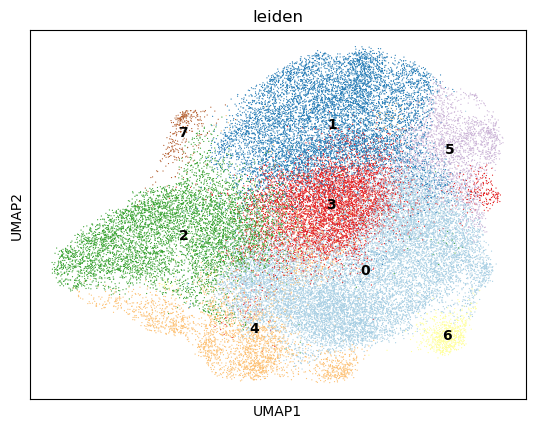

In [50]:
sc.pl.umap(adata, color=['leiden'], palette='Paired',legend_loc='on data', save=f'_{studyID}_microglia_leiden_res{res}.pdf')    

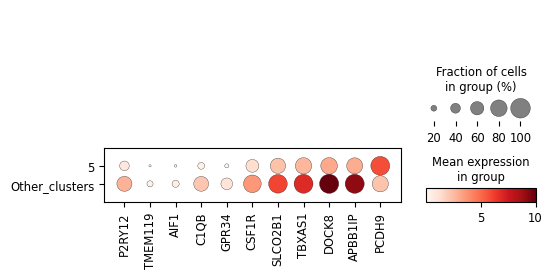

In [51]:
goi=['P2RY12','TMEM119','AIF1','C1QB','CX3R1','GPR34','CSF1R','SLCO2B1','TBXAS1','DOCK8','APBB1IP','PCDH9']

# Create a new variable 'cluster2' in adata.obs
adata.obs['cluster2'] = adata.obs['leiden'].apply(lambda x: '5' if x == '5' else 'Other_clusters')
adata.obs['cluster2'] = adata.obs['cluster2'].astype('category')

goi_in_adata=[gene for gene in goi if gene in adata.var_names]
sc.pl.dotplot(adata, goi_in_adata, groupby="cluster2",save=f'{studyID}_microglia_goi_res{res}_check_microgliaMarker.pdf')

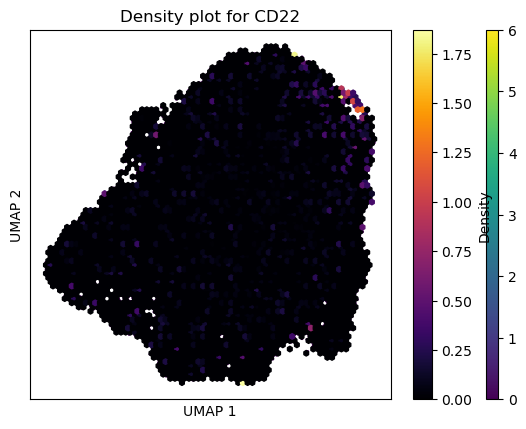

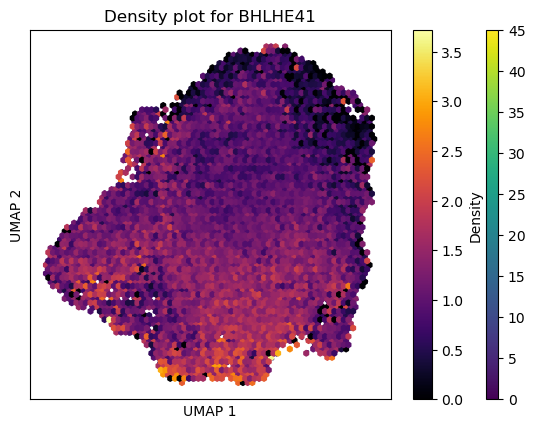

In [52]:
# Importing necessary libraries
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Define the markers you are interested in
markers = ["CD22",'BHLHE41']

# Loop over each marker to create a density plot on UMAP
for marker in markers:
    # Create a UMAP scatter plot colored by marker expression
    sc.pl.umap(adata, color=marker, show=False, cmap='viridis', legend_loc=None,s=20)
    
    # Overlay density (this step is similar to Nebulosa, but done manually)
    ax = plt.gca()  # Get current axis
    
    # Extract UMAP coordinates
    x = adata.obsm['X_umap'][:, 0]  # UMAP 1 coordinates
    y = adata.obsm['X_umap'][:, 1]  # UMAP 2 coordinates
    
    # Extract expression levels of the marker
    expression = adata[:, marker].X.toarray().flatten()
    
   # Create a 2D histogram / density plot
    hexbin_plot = ax.hexbin(x, y, C=expression, gridsize=70, cmap='inferno', reduce_C_function=np.mean, mincnt=1)

    # Set axis labels and title
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(f'Density plot for {marker}')

    # Add the colorbar with the mappable hexbin plot
    plt.colorbar(hexbin_plot, label='Density')
    
    # Save or show the figure
    plt.savefig(f'figures/umap_density_{studyID}_{marker}_within_macrolia.pdf')
    plt.show()

#### BHLHE41/CD22 in different clusters

In [53]:
adata.obs['donor_id'].unique().size

83


Pseudobulk table:
       donor_id        cluster2  BHLHE41–CD22 Tendency Score
0    H18.30.002               5                     0.345197
1    H18.30.002  Other_clusters                     0.576227
2    H19.30.001               5                     0.000000
3    H19.30.001  Other_clusters                     0.515024
4    H19.30.002               5                     0.544493
..          ...             ...                          ...
161  H21.33.045  Other_clusters                     0.776095
162  H21.33.046               5                     0.143354
163  H21.33.046  Other_clusters                     0.700205
164  H21.33.047               5                     0.602245
165  H21.33.047  Other_clusters                     0.936261

[162 rows x 3 columns]

Donor counts → Other Clusters: 83, Cluster 5: 79

--- Mann–Whitney U (Pseudobulk Donor-level) ---
Cluster Other vs Cluster 5 :
Statistic = 6100.00
P = 3.304e-21
Conclusion: Significant donor-level difference between clusters

/var/folders/yn/hz3ff0v92wncd37sxx_wrqhc0000gq/T/ipykernel_85299/951389545.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['donor_id', 'cluster2'])['BHLHE41–CD22 Tendency Score']


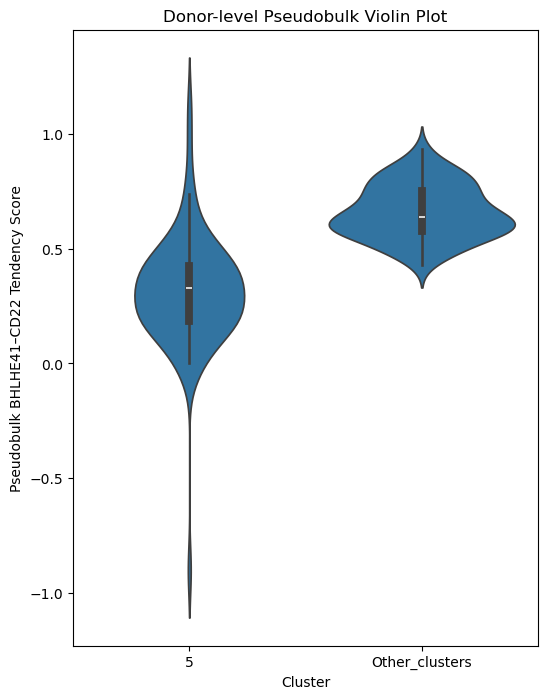

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import scanpy as sc



# Step 1: Compute Exclusive Score per cell
# Get dense expression (safe for two genes only)
bhlhe41 = np.log1p(adata[:, 'BHLHE41'].X.toarray().flatten())
cd22 = np.log1p(adata[:, 'CD22'].X.toarray().flatten())

adata.obs['BHLHE41–CD22 Tendency Score'] = bhlhe41 - cd22

# Step 2: Pseudobulk = donor × cluster summary
# We compute mean Exclusive score per donor per cluster
df = adata.obs[['BHLHE41–CD22 Tendency Score', 'cluster2', 'donor_id']].copy()
df = df.dropna(subset=['BHLHE41–CD22 Tendency Score'])

pseudobulk = (
    df.groupby(['donor_id', 'cluster2'])['BHLHE41–CD22 Tendency Score']
      .mean()
      .reset_index()
)
pseudobulk = pseudobulk.dropna(subset=['BHLHE41–CD22 Tendency Score'])
print("\nPseudobulk table:")
print(pseudobulk)

# Step 3: Prepare data for C5 vs other comparison
cluster_other = pseudobulk[pseudobulk['cluster2'] == 'Other_clusters']['BHLHE41–CD22 Tendency Score']
cluster5 = pseudobulk[pseudobulk['cluster2'] == '5']['BHLHE41–CD22 Tendency Score']

print(f"\nDonor counts → Other Clusters: {len(cluster_other)}, Cluster 5: {len(cluster5)}")

# Step 4: Statistical testing (Wilcoxon rank-sum on donors)
from scipy.stats import mannwhitneyu
statistic, p_value = mannwhitneyu(cluster_other, cluster5, alternative='two-sided')

print("\n--- Mann–Whitney U (Pseudobulk Donor-level) ---")
print(f"Cluster Other vs Cluster 5 :")
print(f"Statistic = {statistic:.2f}")
print(f"P = {p_value:.3e}")

if p_value < 0.05:
    print("Conclusion: Significant donor-level difference between clusters.")
else:
    print("Conclusion: No significant donor-level difference between clusters.")


# Step 5: Plot donor-level pseudobulk results
import seaborn as sns
import matplotlib.pyplot as plt

# violin plot
plot_df = pseudobulk[['cluster2', 'BHLHE41–CD22 Tendency Score']].copy()
plot_df['cluster2'] = plot_df['cluster2'].astype(str)   # ensure string labels

plt.figure(figsize=(6,8))
sns.violinplot(data=plot_df, x='cluster2', y='BHLHE41–CD22 Tendency Score', inner='box')
plt.xlabel("Cluster")
plt.ylabel("Pseudobulk BHLHE41–CD22 Tendency Score")
plt.title("Donor-level Pseudobulk Violin Plot")
plt.savefig(f'figures/{studyID}_Violin_B41vsCD22_cluster.pdf')
plt.show()
